# Trains classification models to predict what the image is

## About the dataset:

The dataset consists of 150 x 150 px images of the following:
- Buildings
- Streets
- Forests
- Mountains
- Glaciers
- Seas

## Import the necessary packages

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from os import listdir
from random import shuffle

## Load training and testing data

In [2]:
CATEGORIES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
TRAINING_DATA_PATH = './data/seg_train/seg_train/'
TESTING_DATA_PATH = './data/seg_test/seg_test/'

In [3]:
def load_images(path: str, category1: str, category2: str, reshape=True, standardize=True, shuffle_images=True):
    """Loads all images from specified directory into a numpy array and shuffles it.

    Args:
        path (str): Path to folder containing categories of images.
        category1 (str): name of folder containing images of category 1.
        category2 (str): name of folder containing images of category 2.
        reshape (bool, optional): Should the images be reshaped into a column matrix. Defaults to True.
        standardize (bool, optional): Should the rgb values be standardized. Defaults to True.
        shuffle_images (bool, optional): Should the images be shuffled. Defaults to True.

    Returns:
        images (ndarray): Numpy array containing all images
        labels (ndarray): Numpy array containing all labels
    """
    print(category1, category2)

    categories = (category1, category2)

    images = []
    labels = []

    for i in range(2):
        path_to_category = path + categories[i] + '/'
        for filename in listdir(path_to_category):
            img = Image.open(path_to_category + filename)
            img = img.resize([150, 150])
            img = np.array(img)
            if reshape: img = img.reshape(150*150*3)
            if standardize: img = img / 255
            images.append(img)
            labels.append(i)

    if shuffle_images: 
        data = list(zip(images, labels))
        shuffle(data)
        images, labels = zip(*data)

    return np.stack(images), np.stack(labels)

In [4]:
def load_data(category1, category2):
    """Load training and testing data.

    Args:
        category1 (u_int): Category 1 index.
        category2 (u_int): Category 2 index.

    Returns:
        tuple: Tuple containing training and testing data.
    """
    training_data, training_labels = load_images(TRAINING_DATA_PATH, CATEGORIES[category1], CATEGORIES[category2], shuffle_images=True)
    testing_data, testing_labels = load_images(TESTING_DATA_PATH, CATEGORIES[category1], CATEGORIES[category2], shuffle_images=True)

    training_labels = training_labels.reshape((training_labels.shape[0], 1))
    testing_labels = testing_labels.reshape((testing_labels.shape[0], 1))

    return training_data, training_labels, testing_data, testing_labels

In [5]:
training_data, training_labels, testing_data, testing_labels = load_data(2, 5)

glacier street
glacier street


In [6]:
training_data.shape, training_labels.shape

((4786, 67500), (4786, 1))

(<matplotlib.image.AxesImage at 0x7ff4d4215fc0>, array([1]))

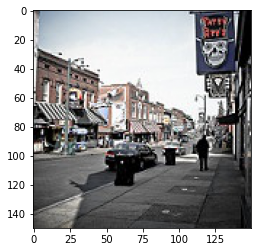

In [13]:
plt.imshow(training_data[0].reshape(150, 150, 3)), training_labels[0]

## Create classifier class which trains a model

In [14]:
class Classifier:
    def __init__(self, training_data: np.ndarray, training_labels: np.ndarray, testing_data: np.ndarray, testing_labels: np.ndarray):
        self.training_data = training_data
        self.training_labels = training_labels.T
        self.testing_labels = testing_labels
        self.testing_data = testing_data.T

        # Initialize parameters (m, c) with zeros
        self.m = np.zeros((1, training_data.shape[1]))
        self.c = float(0)

    def sigmoid(self, x: np.ndarray):
        """Returns sigmoid of numpy array.

        Args:
            x (numpy array): Array for which sigmoid should be calculated.

        Returns:
            numpy array: Array with sigmoid applied.
        """
        return 1/(1+np.exp(-x))


    def cost(self, y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
        """Returns cost of model.

        Args:
            y (numpy array): Array of correct labels.
            y_hat (numpy array): Array of predicted labels.

        Returns:
            ndarray: Cost of model.
        """
        return (-1 / y.shape[0]) * np.sum(np.dot(y, np.log(y_hat + 1e-5).T) + np.dot((1 - y), np.log(1 - y_hat + 1e-5).T), axis = 1)
    

    def predict(self, X: np.ndarray):
        """Predicts labels for given data using the formula: y = m*x + c.

        Args:
            X (numpy array): Numpy array containing all the images which need to be classified.

        Returns:
            numpy array: Labels for given data.
            numpy array: Numerical prediction ranging from 0 to 1.
        """
        
        prediction = self.sigmoid(np.dot(self.m, X.T) + self.c)
        label = np.where(prediction > 0.5, 1, 0)
        return label, prediction


    def train(self, epochs: int = 100, learning_rate: float = 0.01, debug_print_rate = 10):
        """Trains the model for given number of epochs"""

        for epoch in range(1, epochs + 1):
            cost = self.train_one_iteration(self.training_data, self.training_labels, learning_rate)
            if epoch % debug_print_rate == 0:
                yield epoch, cost


    def train_one_iteration(self, X: np.ndarray, Y: np.ndarray, learning_rate: float):
        """Trains the model for 1 iteration.

        Args:
            X (numpy array): Numpy array of images to be used for training
            Y (numpy array): Numpy array of labels for images for training
            learning_rate (float): Learning rate for gradient descent.
        """
    
        # Predict
        _, prediction = self.predict(X)
        cost = self.cost(Y, prediction)
        cost = np.squeeze(np.array(cost))

        # Update parameters
        dm = (1 / X.shape[0]) * np.dot((prediction - Y), X)
        dc = (1 / X.shape[0]) * (prediction - Y)
        self.m = self.m - learning_rate * dm
        self.c = (self.c - learning_rate * dc)[0][0]
        return cost

In [22]:
classifier = Classifier(training_data[:], training_labels[:], testing_data, testing_labels)
classifier.train(epochs=100, learning_rate=0.01, debug_print_rate=10)

Epoch 10: Cost: 25528.21335610689
Epoch 20: Cost: 26894.612332052635
Epoch 30: Cost: 21281.755665407825
Epoch 40: Cost: 20327.82652794471
Epoch 50: Cost: 16982.769934940698
Epoch 60: Cost: 14833.676944904633
Epoch 70: Cost: 13819.857484196355
Epoch 80: Cost: 13264.200251707003
Epoch 90: Cost: 12773.666024249082
Epoch 100: Cost: 12494.302727938024


In [23]:
predictions = classifier.predict(testing_data)[0].T
accuracy = predictions == testing_labels
print(accuracy.sum(), '/', predictions.shape[0])
accuracy.sum() / predictions.shape[0]

763 / 1054


0.7239089184060721

glacier
glacier
street
glacier
street


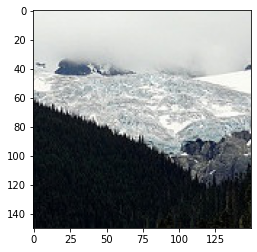

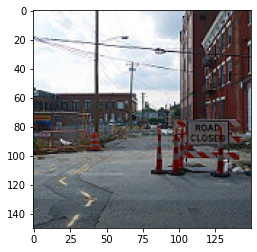

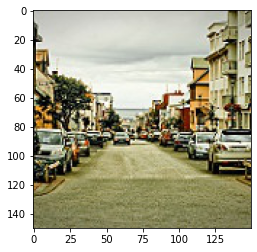

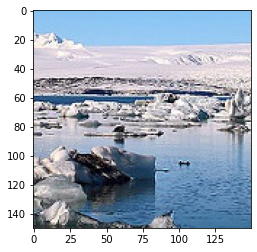

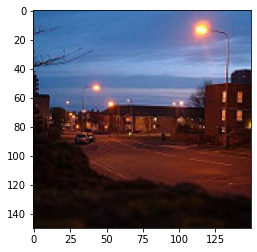

In [20]:
ims = [i + 10 for i in range(5)]
for i in ims:
    plt.figure()
    plt.imshow(testing_data[i].reshape(150, 150, 3))
    print('glacier' if classifier.predict(testing_data[i])[0][0] == 0 else 'street')